In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Loading the filtered dataset
distributed_df = pd.read_csv('filtered_df.csv')
print(distributed_df.head())

# Setting 'Gene_ID' as index without inplace modification
filtered_distributed_df = distributed_df.loc[:, distributed_df.columns.str.contains('Average')]

    Gene_ID           Transcript_ID  Average Oocyte(RPKM)  \
0  C9orf152          NM_001012993,                  0.000   
1     RPS11             NM_001015,               1057.517   
2     ELMO2  NM_133171, NM_182764,                  9.486   
3   CREB3L1             NM_052854,                  1.457   
4     PNMA1             NM_006029,                  1.382   

   Average Zygote(RPKM)  Average 2-cell embryo(RPKM)  \
0                 0.000                        0.036   
1               850.277                     1507.581   
2                60.506                       55.716   
3                 1.323                        1.231   
4                 5.421                        3.781   

   Average 4-cell embryo(RPKM)  Average 8-cell embryo(RPKM)  \
0                        0.000                        0.095   
1                     3971.046                     4303.018   
2                       66.985                       12.810   
3                        2.079              

In [4]:
# Computing total per sample
total_counts = filtered_distributed_df.sum(axis=0)

In [5]:
# log transformation
log_counts = filtered_distributed_df.apply(lambda x: np.log2(x + 1))

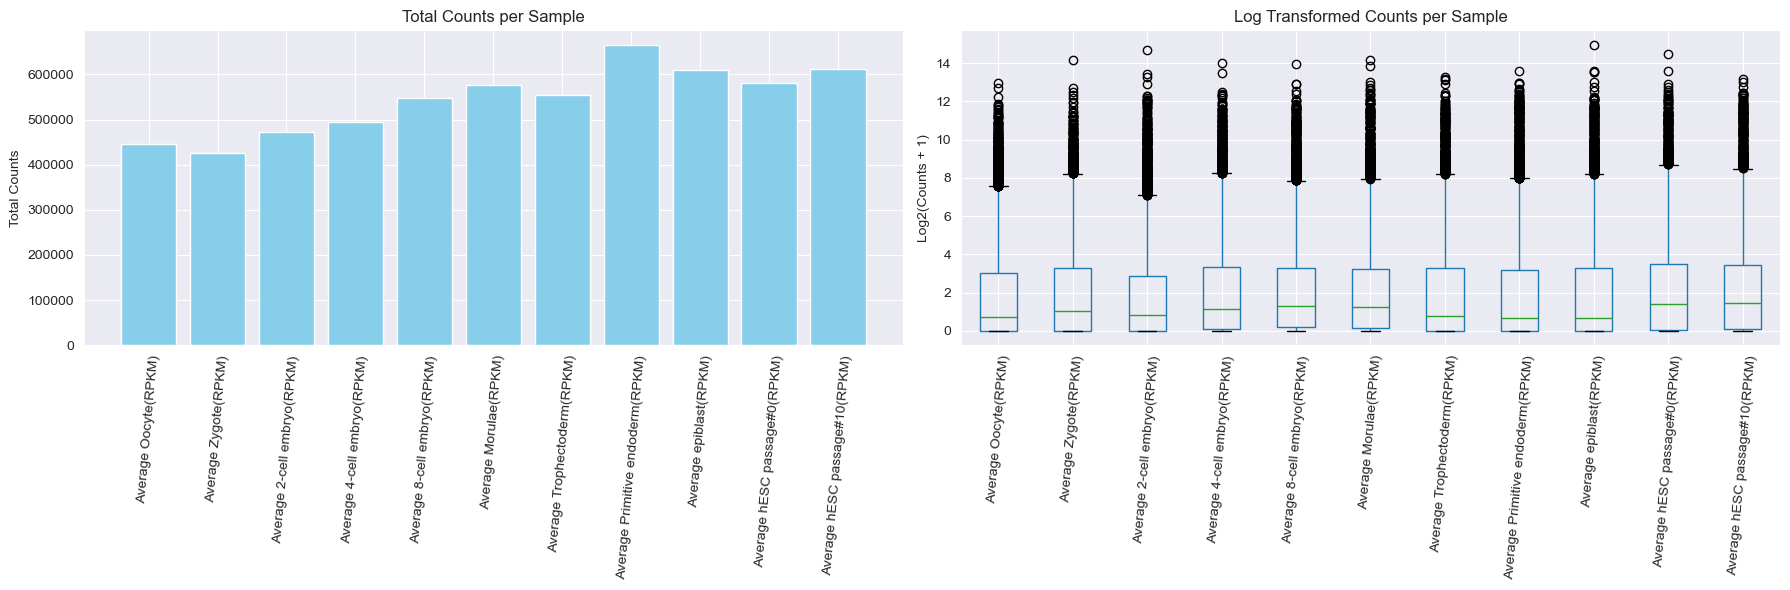

In [6]:

# plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: total counts per sample "Total Counts," helps visualize the overall
# sequencing depth across the samples. Ideally, the bars, representing the total
# counts, should be of similar height, indicating that sequencing depth
# is consistent across samples, which is the case with this data set.

#Conversely, the rightmost chart is used to assess the variability and
#distribution of gene expression counts across samples. the boxes, representing
#the interquartile range, and the whiskers, representing variability outside the
# upper and lower quartiles, are of similar sizes across the samples, indicating
# a consistent data distribution.
axes[0].bar(total_counts.index, total_counts.values, color='skyblue')
axes[0].set_ylabel('Total Counts')
axes[0].set_title('Total Counts per Sample')
axes[0].tick_params(axis='x', rotation=85)

# Subplot 2: Transf log
log_counts.boxplot(ax=axes[1])
axes[1].set_ylabel('Log2(Counts + 1)')
axes[1].set_title('Log Transformed Counts per Sample')
axes[1].tick_params(axis='x', rotation=85)

plt.tight_layout()
plt.show()


In [7]:
!pip install scipy
import scipy.cluster.hierarchy as sch

In [8]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

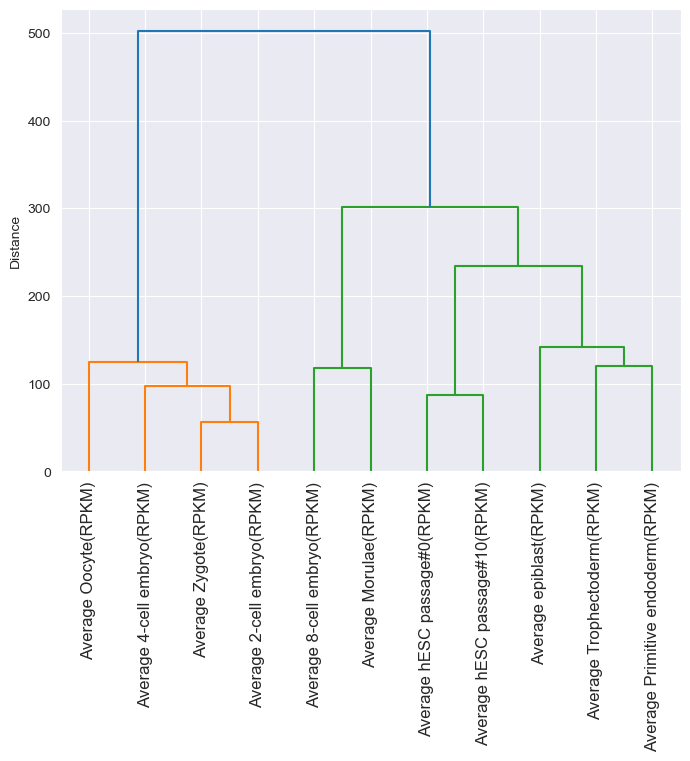

In [9]:
#Dendogram
h_clustering = sch.linkage(log_counts.T, 'ward')
plt.figure(figsize=(8, 6))
dendrogram(h_clustering, labels=filtered_distributed_df.columns)
plt.xticks(rotation=90)
plt.ylabel('Distance')
plt.show()

In [10]:
# Filtering genes with low expression
rpkm_columns = [
    'Average Oocyte(RPKM)',
    'Average Zygote(RPKM)',
    'Average 2-cell embryo(RPKM)',
    'Average 4-cell embryo(RPKM)',
    'Average 8-cell embryo(RPKM)',
    'Average Morulae(RPKM)',
    'Average Trophectoderm(RPKM)',
    'Average Primitive endoderm(RPKM)',
    'Average epiblast(RPKM)',
    'Average hESC passage#0(RPKM)',
    'Average hESC passage#10(RPKM)'
]

# Rechecking all columns have float values
distributed_df[rpkm_columns] = distributed_df[rpkm_columns].apply(pd.to_numeric, errors='coerce')

# Function to filter the genes
def filter_genes(data, min_rpkm=1, min_samples=3):
    # Mask to check if the values are higher then the treshold
    mask = (data[rpkm_columns] > min_rpkm).sum(axis=1) >= min_samples
    # Return only the selected rows
    return data[mask]

# Applying the filter genes
df_filtered = filter_genes(distributed_df) #df to work with in the upcoming analysis
print(df_filtered.head())


   Gene_ID              Transcript_ID  Average Oocyte(RPKM)  \
1    RPS11                NM_001015,               1057.517   
2    ELMO2     NM_133171, NM_182764,                  9.486   
3  CREB3L1                NM_052854,                  1.457   
4    PNMA1                NM_006029,                  1.382   
5     MMP2  NM_001127891, NM_004530,                  0.000   

   Average Zygote(RPKM)  Average 2-cell embryo(RPKM)  \
1               850.277                     1507.581   
2                60.506                       55.716   
3                 1.323                        1.231   
4                 5.421                        3.781   
5                 0.000                        0.000   

   Average 4-cell embryo(RPKM)  Average 8-cell embryo(RPKM)  \
1                     3971.046                     4303.018   
2                       66.985                       12.810   
3                        2.079                        0.675   
4                        3.364  

In [11]:
print(df_filtered.head(5))

   Gene_ID              Transcript_ID  Average Oocyte(RPKM)  \
1    RPS11                NM_001015,               1057.517   
2    ELMO2     NM_133171, NM_182764,                  9.486   
3  CREB3L1                NM_052854,                  1.457   
4    PNMA1                NM_006029,                  1.382   
5     MMP2  NM_001127891, NM_004530,                  0.000   

   Average Zygote(RPKM)  Average 2-cell embryo(RPKM)  \
1               850.277                     1507.581   
2                60.506                       55.716   
3                 1.323                        1.231   
4                 5.421                        3.781   
5                 0.000                        0.000   

   Average 4-cell embryo(RPKM)  Average 8-cell embryo(RPKM)  \
1                     3971.046                     4303.018   
2                       66.985                       12.810   
3                        2.079                        0.675   
4                        3.364  

In [12]:
# Transposing the df to apply PCA
df_filtered = df_filtered.drop(columns=['Transcript_ID'])

#Selecting columns with the 'Avg' word
expression_columns = [col for col in df_filtered.columns if 'Average' in col]

#  Stablishing 'Gene_ID' as index
df_filtered.set_index('Gene_ID', inplace=True)

# Transposing the df
df_transposed = df_filtered[expression_columns].transpose()

# Rechecking 
print(df_transposed.head())  
print(df_transposed.shape)  



Gene_ID                         RPS11   ELMO2  CREB3L1   PNMA1   MMP2  \
Average Oocyte(RPKM)         1057.517   9.486    1.457   1.382  0.000   
Average Zygote(RPKM)          850.277  60.506    1.323   5.421  0.000   
Average 2-cell embryo(RPKM)  1507.581  55.716    1.231   3.781  0.000   
Average 4-cell embryo(RPKM)  3971.046  66.985    2.079   3.364  0.000   
Average 8-cell embryo(RPKM)  4303.018  12.810    0.675  27.055  0.286   

Gene_ID                      TMEM216  C10orf90    ZHX3   ERCC5  APBB2  ...  \
Average Oocyte(RPKM)          11.753     1.955  19.978  21.522  6.773  ...   
Average Zygote(RPKM)           2.259     0.900  33.526  17.848  8.088  ...   
Average 2-cell embryo(RPKM)    3.233     1.246  29.647  10.448  5.123  ...   
Average 4-cell embryo(RPKM)    6.653     1.438  44.984  18.728  9.765  ...   
Average 8-cell embryo(RPKM)    1.532     0.161   4.443  11.366  6.109  ...   

Gene_ID                      SLC2A11   SELO  GOLGA8B   GPLD1   RAB8A   PCIF1  \
Average Oocy

In [13]:
# PCA analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

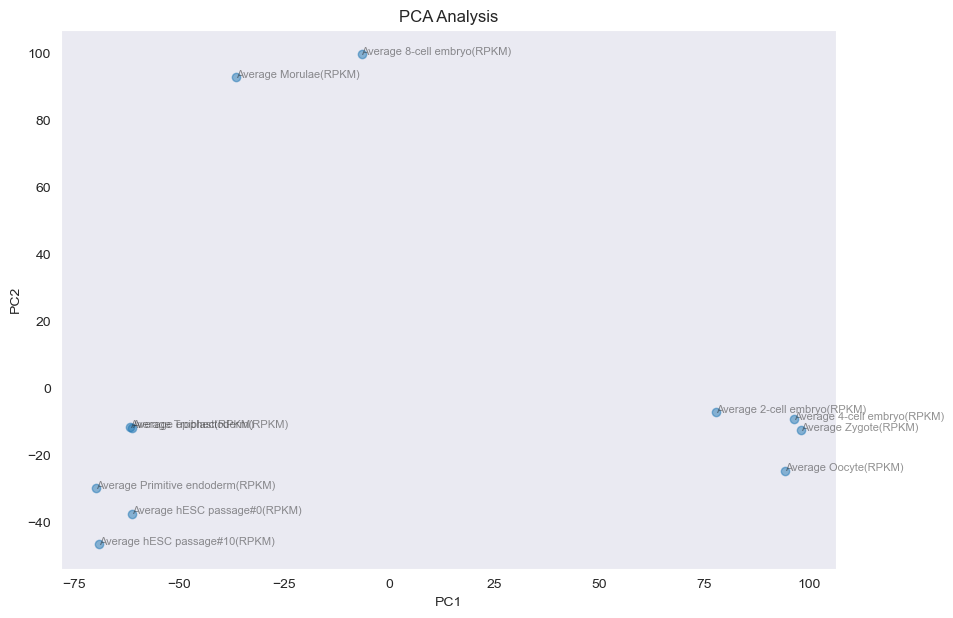

In [14]:
# Applying the PCA to the transposed df and scaling it
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Data Scaling
scaler = StandardScaler()

# Scaling the data 
data_normalized = scaler.fit_transform(df_transposed)

# Applying PCA
pca = PCA(n_components=2)  
principal_components = pca.fit_transform(data_normalized)

# Creation of the df with the normalized data
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Adding genes
pca_df['Gene_ID'] = df_transposed.index

# PCA plot
plt.figure(figsize=(10,7))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)

# Labels to the PCA plot
for i in range(pca_df.shape[0]):
    plt.annotate(pca_df['Gene_ID'].iloc[i],
                 (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]),
                 fontsize=8, alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Analysis')
plt.grid()
plt.show()


In [18]:
#Adding elypsoids 
from sklearn.mixture import GaussianMixture

In [19]:

gmm = GaussianMixture(n_components=3) 
gmm_labels = gmm.fit_predict(pca_df[['PC1', 'PC2']])

# Añadimos las etiquetas de grupo al DataFrame
pca_df['Cluster'] = gmm_labels


/Users/danielaalejandragonzalez/opt/anaconda3/lib/python3.12/site-packages/matplotlib/patches.py:1566: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center = (self.convert_xunits(self._center[0]),
/Users/danielaalejandragonzalez/opt/anaconda3/lib/python3.12/site-packages/matplotlib/patches.py:1567: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.convert_yunits(self._center[1]))
/Users/danielaalejandragonzalez/opt/anaconda3/lib/python3.12/site-packages/matplotlib/patches.py:1566: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

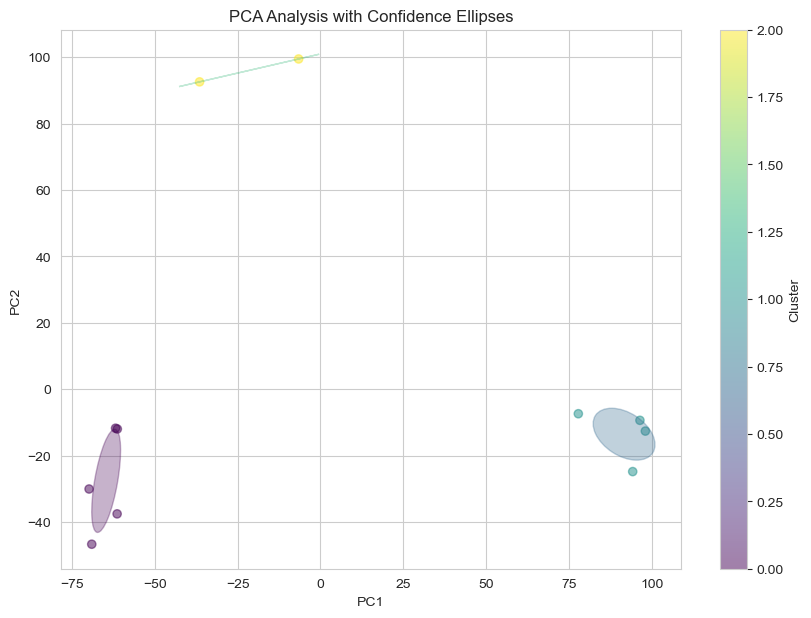

In [20]:
from matplotlib.patches import Ellipse

# Function to draw the ellipsoids
def draw_ellipse(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Ordering the eigenvalues and eigenvectors
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    
    angle = np.arctan2(*eigenvectors[:, 0][::-1])
    angle = 180.0 * angle / np.pi  

   
    width, height = 2.0 * np.sqrt(eigenvalues)

   
    ellipse = Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor=color, alpha=0.3)
    ax.add_patch(ellipse)

# PCA plot
plt.figure(figsize=(10, 7))

# Each PCA point with a colour
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.5)


for cluster in np.unique(pca_df['Cluster']):
    group_data = pca_df[pca_df['Cluster'] == cluster]
    mean = group_data[['PC1', 'PC2']].mean(axis=0) 
    cov = np.cov(group_data[['PC1', 'PC2']], rowvar=False) 

    draw_ellipse(plt.gca(), mean, cov, color=plt.cm.viridis(cluster / np.unique(pca_df['Cluster']).size))


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Analysis with Confidence Ellipses')
plt.grid(True)
plt.colorbar(label='Cluster')


plt.show()


In [22]:
df_filtered


,Average Oocyte(RPKM),Average Zygote(RPKM),Average 2-cell embryo(RPKM),Average 4-cell embryo(RPKM),Average 8-cell embryo(RPKM),Average Morulae(RPKM),Average Trophectoderm(RPKM),Average Primitive endoderm(RPKM),Average epiblast(RPKM),Average hESC passage#0(RPKM),Average hESC passage#10(RPKM)
Gene_ID,,,,,,,,,,,
RPS11,1057.517,850.277,1507.581,3971.046,4303.018,2895.275,1384.116,2670.108,1968.631,2070.786,2659.038
ELMO2,9.486,60.506,55.716,66.985,12.810,5.074,2.296,0.225,3.047,3.410,2.937
CREB3L1,1.457,1.323,1.231,2.079,0.675,0.094,0.000,4.285,1.625,3.318,4.076
PNMA1,1.382,5.421,3.781,3.364,27.055,34.535,12.948,9.106,15.112,18.029,11.297
MMP2,0.000,0.000,0.000,0.000,0.286,0.064,0.012,0.419,20.926,2.909,5.764
...,...,...,...,...,...,...,...,...,...,...,...
PCIF1,11.491,19.658,14.117,28.495,6.947,1.475,1.183,5.650,5.468,5.486,9.044
PIK3IP1,0.067,0.078,0.000,0.191,3.155,15.420,0.000,0.000,0.185,1.041,0.543
SNRPD2,49.915,35.246,31.003,57.497,163.262,243.481,220.804,419.320,285.818,453.738,581.603


             PC1       PC2  Gene_ID
0      26.736977  1.269622    RPS11
1      -0.255106  0.228613    ELMO2
2      -0.461271 -0.054908  CREB3L1
3      -0.332252 -0.097988    PNMA1
4      -0.456167 -0.075105     MMP2
...          ...       ...      ...
12973  -0.365861  0.041929    PCIF1
12974  -0.460181 -0.063152  PIK3IP1
12975   2.154236 -1.292711   SNRPD2
12976  -0.072895  0.276454  SLC39A6
12977  -0.140737 -0.117416     CTSC

[12978 rows x 3 columns]


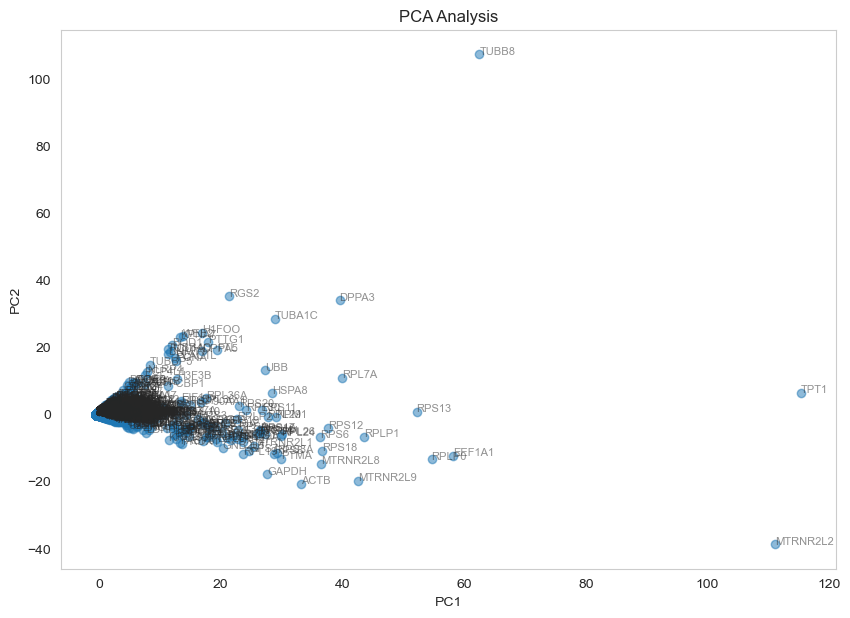

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Restablishing the index
df_filtered = df_filtered.reset_index()

# Defining RPKM values
rpkm_columns = [
    'Average Oocyte(RPKM)', 'Average Zygote(RPKM)', 'Average 2-cell embryo(RPKM)', 
    'Average 4-cell embryo(RPKM)', 'Average 8-cell embryo(RPKM)', 'Average Morulae(RPKM)', 
    'Average Trophectoderm(RPKM)', 'Average Primitive endoderm(RPKM)', 'Average epiblast(RPKM)', 
    'Average hESC passage#0(RPKM)', 'Average hESC passage#10(RPKM)'
]

# Selecting the data
data_PCA = df_filtered[rpkm_columns]

# Normalization
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_PCA)

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_normalized)

# Creation of the df with the PCA VALUES
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Adding the  Gene_ID to the  DataFrame of PCA
pca_df['Gene_ID'] = df_filtered['Gene_ID']


print(pca_df)

# PCA plot
plt.figure(figsize=(10, 7))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
for i in range(pca_df.shape[0]):
    plt.annotate(pca_df['Gene_ID'].iloc[i], (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), fontsize=8, alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Analysis')
plt.grid()
plt.show()



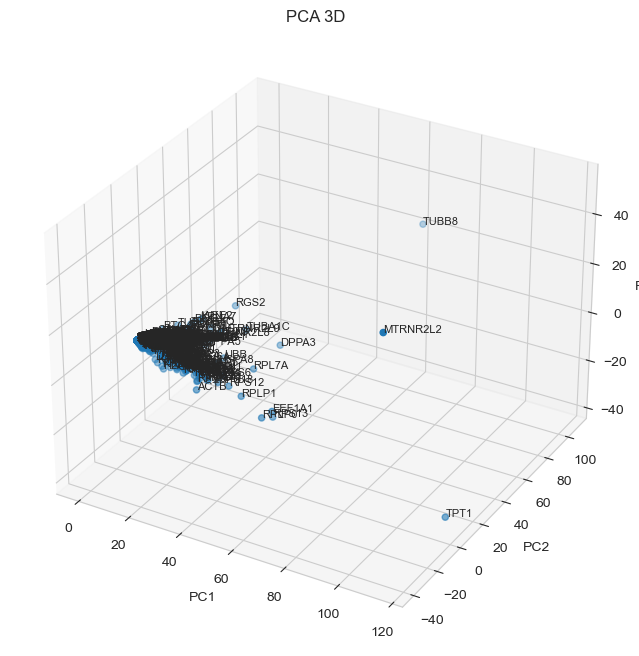

In [26]:
# Adjusting the number of PCA
# PCA with 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_normalized)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2])


for i in range(pca_result.shape[0]):
    ax.text(pca_result[i, 0], pca_result[i, 1], pca_result[i, 2], df_filtered['Gene_ID'].values[i], size=8)

ax.set_title('PCA 3D ')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()


In [27]:
df_filtered


,Gene_ID,Average Oocyte(RPKM),Average Zygote(RPKM),Average 2-cell embryo(RPKM),Average 4-cell embryo(RPKM),Average 8-cell embryo(RPKM),Average Morulae(RPKM),Average Trophectoderm(RPKM),Average Primitive endoderm(RPKM),Average epiblast(RPKM),Average hESC passage#0(RPKM),Average hESC passage#10(RPKM)
0,RPS11,1057.517,850.277,1507.581,3971.046,4303.018,2895.275,1384.116,2670.108,1968.631,2070.786,2659.038
1,ELMO2,9.486,60.506,55.716,66.985,12.810,5.074,2.296,0.225,3.047,3.410,2.937
2,CREB3L1,1.457,1.323,1.231,2.079,0.675,0.094,0.000,4.285,1.625,3.318,4.076
3,PNMA1,1.382,5.421,3.781,3.364,27.055,34.535,12.948,9.106,15.112,18.029,11.297
4,MMP2,0.000,0.000,0.000,0.000,0.286,0.064,0.012,0.419,20.926,2.909,5.764
...,...,...,...,...,...,...,...,...,...,...,...,...
12973,PCIF1,11.491,19.658,14.117,28.495,6.947,1.475,1.183,5.650,5.468,5.486,9.044
12974,PIK3IP1,0.067,0.078,0.000,0.191,3.155,15.420,0.000,0.000,0.185,1.041,0.543
12975,SNRPD2,49.915,35.246,31.003,57.497,163.262,243.481,220.804,419.320,285.818,453.738,581.603
12976,SLC39A6,39.674,56.162,64.340,90.990,31.536,37.025,10.084,6.872,14.652,18.171,17.851


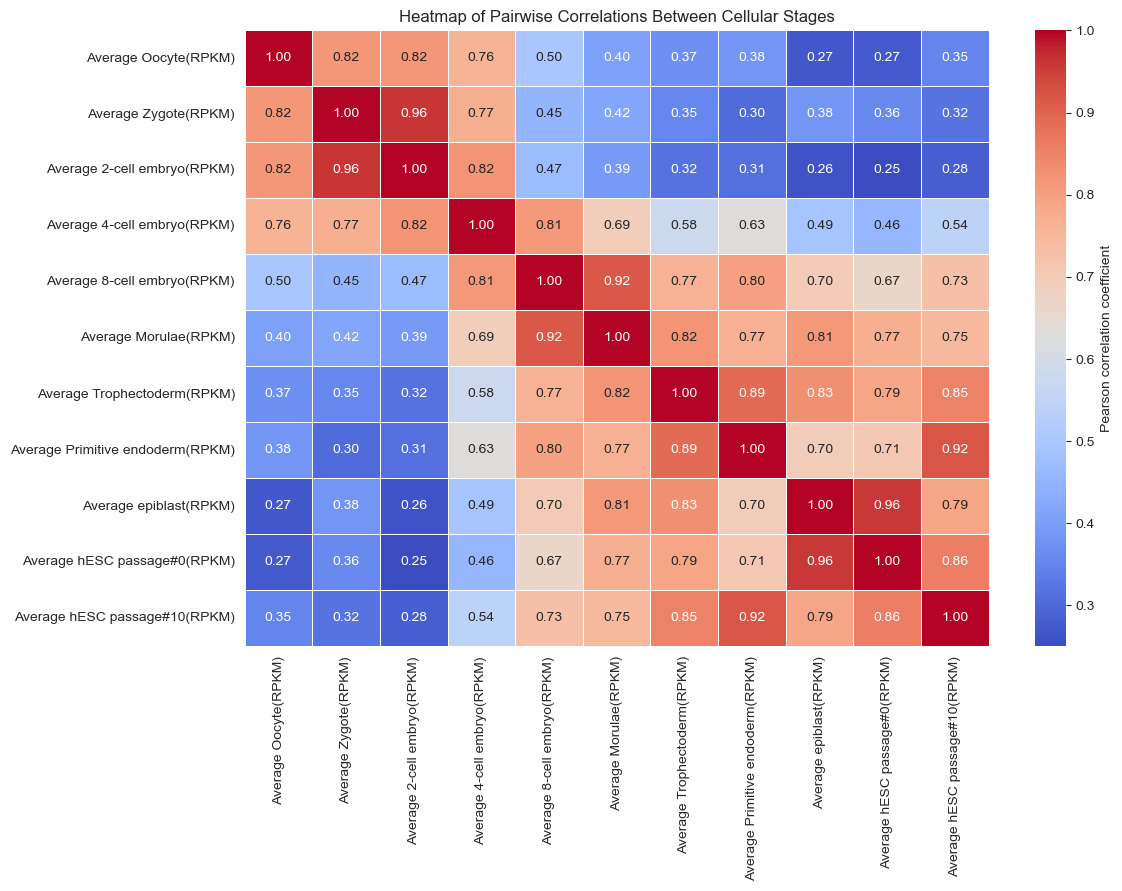

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
#Establishing the gene_id as index
df_filtered.set_index('Gene_ID', inplace=True)

df_transposed = df_filtered

# Computing correlation matrix between the different cells stages
correlation_matrix = df_transposed.corr(method='pearson')

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'label': 'Pearson correlation coefficient'})
plt.title('Heatmap of Pairwise Correlations Between Cellular Stages')
plt.show()




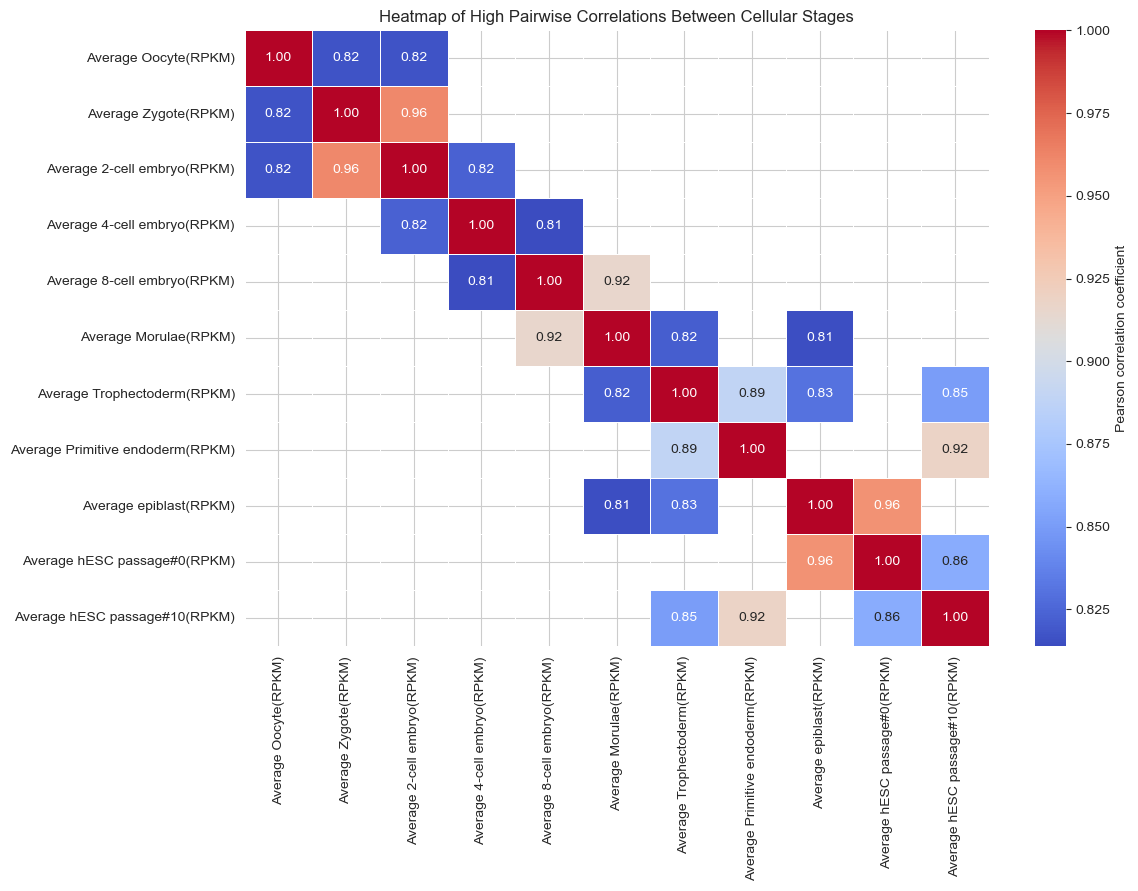

In [30]:
# Filtering corr values higher than 0.8
high_corr_matrix = correlation_matrix[correlation_matrix > 0.8]

# Corr plot
plt.figure(figsize=(12, 8))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'label': 'Pearson correlation coefficient'})
plt.title('Heatmap of High Pairwise Correlations Between Cellular Stages')
plt.show()


In [31]:
#hasta aca tengo el df filtered transpuesto con los gene_id como index
df_filtered

,Average Oocyte(RPKM),Average Zygote(RPKM),Average 2-cell embryo(RPKM),Average 4-cell embryo(RPKM),Average 8-cell embryo(RPKM),Average Morulae(RPKM),Average Trophectoderm(RPKM),Average Primitive endoderm(RPKM),Average epiblast(RPKM),Average hESC passage#0(RPKM),Average hESC passage#10(RPKM)
Gene_ID,,,,,,,,,,,
RPS11,1057.517,850.277,1507.581,3971.046,4303.018,2895.275,1384.116,2670.108,1968.631,2070.786,2659.038
ELMO2,9.486,60.506,55.716,66.985,12.810,5.074,2.296,0.225,3.047,3.410,2.937
CREB3L1,1.457,1.323,1.231,2.079,0.675,0.094,0.000,4.285,1.625,3.318,4.076
PNMA1,1.382,5.421,3.781,3.364,27.055,34.535,12.948,9.106,15.112,18.029,11.297
MMP2,0.000,0.000,0.000,0.000,0.286,0.064,0.012,0.419,20.926,2.909,5.764
...,...,...,...,...,...,...,...,...,...,...,...
PCIF1,11.491,19.658,14.117,28.495,6.947,1.475,1.183,5.650,5.468,5.486,9.044
PIK3IP1,0.067,0.078,0.000,0.191,3.155,15.420,0.000,0.000,0.185,1.041,0.543
SNRPD2,49.915,35.246,31.003,57.497,163.262,243.481,220.804,419.320,285.818,453.738,581.603


In [32]:
df_transposed

,Average Oocyte(RPKM),Average Zygote(RPKM),Average 2-cell embryo(RPKM),Average 4-cell embryo(RPKM),Average 8-cell embryo(RPKM),Average Morulae(RPKM),Average Trophectoderm(RPKM),Average Primitive endoderm(RPKM),Average epiblast(RPKM),Average hESC passage#0(RPKM),Average hESC passage#10(RPKM)
Gene_ID,,,,,,,,,,,
RPS11,1057.517,850.277,1507.581,3971.046,4303.018,2895.275,1384.116,2670.108,1968.631,2070.786,2659.038
ELMO2,9.486,60.506,55.716,66.985,12.810,5.074,2.296,0.225,3.047,3.410,2.937
CREB3L1,1.457,1.323,1.231,2.079,0.675,0.094,0.000,4.285,1.625,3.318,4.076
PNMA1,1.382,5.421,3.781,3.364,27.055,34.535,12.948,9.106,15.112,18.029,11.297
MMP2,0.000,0.000,0.000,0.000,0.286,0.064,0.012,0.419,20.926,2.909,5.764
...,...,...,...,...,...,...,...,...,...,...,...
PCIF1,11.491,19.658,14.117,28.495,6.947,1.475,1.183,5.650,5.468,5.486,9.044
PIK3IP1,0.067,0.078,0.000,0.191,3.155,15.420,0.000,0.000,0.185,1.041,0.543
SNRPD2,49.915,35.246,31.003,57.497,163.262,243.481,220.804,419.320,285.818,453.738,581.603


Differentially expressed genes:
       Gene_ID    log2fc    t_stat     p_val     p_adj  abs_log2fc
80     DCAF4L1 -2.502053  7.234054  0.000049  0.006274    2.502053
82       PPIL1  1.817192 -6.962395  0.000066  0.006575    1.817192
88      ZDHHC6  2.052611 -6.653352  0.000093  0.007287    2.052611
123    SEC14L1 -2.472281  6.796898  0.000079  0.006818    2.472281
132    CXorf56 -1.802852  6.908750  0.000070  0.006575    1.802852
...        ...       ...       ...       ...       ...         ...
12837     CCT5  2.928284 -6.206535  0.000158  0.007808    2.928284
12849    POMT2  1.457308 -8.085390  0.000020  0.005331    1.457308
12881   ZNF436 -2.652418  6.642812  0.000095  0.007287    2.652418
12898    TMED1  2.394219 -5.582117  0.000342  0.009818    2.394219
12940  C2orf74  2.973000 -7.958592  0.000023  0.005347    2.973000

[463 rows x 6 columns]


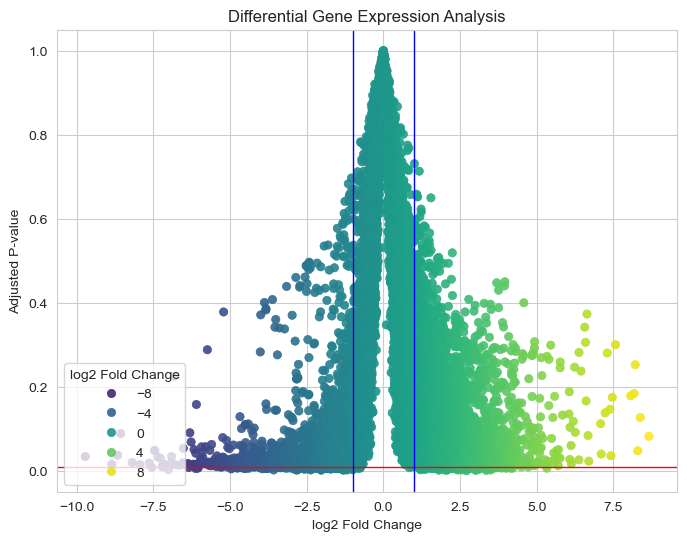

In [33]:
#DGE
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt


# Specifying the  group cells to be compared
control_columns = ['Average Oocyte(RPKM)', 'Average Zygote(RPKM)', 'Average 2-cell embryo(RPKM)', 'Average 4-cell embryo(RPKM)', 'Average 8-cell embryo(RPKM)']
treated_columns = ['Average Morulae(RPKM)', 'Average Trophectoderm(RPKM)', 'Average Primitive endoderm(RPKM)', 'Average epiblast(RPKM)', 'Average hESC passage#0(RPKM)', 'Average hESC passage#10(RPKM)']

# checking that all columns are in the df_transposed
assert all(col in df_transposed.columns for col in control_columns)
assert all(col in df_transposed.columns for col in treated_columns)

# Empty list to store the results
results = []

# For loop to iterate over each line
for gene in df_transposed.index:
    control = df_transposed.loc[gene, control_columns]
    treated = df_transposed.loc[gene, treated_columns]
    
    # Computing the mean for each group
    mean_control = np.mean(control)
    mean_treated = np.mean(treated)
    
    # log2 fold change ( added 1 to avoidlog(0))
    log2fc = np.log2((mean_treated + 1) / (mean_control + 1))
    
    # t-test
    t_stat, p_val = ttest_ind(control, treated)
    
    
    results.append({
        'Gene_ID': gene, 
        'log2fc': log2fc, 
        't_stat': t_stat, 
        'p_val': p_val
    })

# Results to df
results_df = pd.DataFrame(results)


results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

# computation of the absolute log2 fold change to filter
results_df['abs_log2fc'] = results_df['log2fc'].abs()

# Filtering results to get genes diferentially expressed(DEGs)
deg = results_df[(results_df['p_adj'] < 0.01) & (results_df['abs_log2fc'] > 1)]

# results
print(f"Differentially expressed genes:\n{deg}")

# Volcano plot

# Scatterplot of log2FC vs P-valor adjusted
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None)
plt.axhline(y=0.01, color='red', linestyle='-', linewidth=1)  
plt.axvline(x=1, color='blue', linestyle='-', linewidth=1)   
plt.axvline(x=-1, color='blue', linestyle='-', linewidth=1)  
plt.xlabel('log2 Fold Change')
plt.ylabel('Adjusted P-value')
plt.title('Differential Gene Expression Analysis')
plt.legend(title='log2 Fold Change', loc='lower left')
plt.show()


In [39]:
# Filtering the group of DGE genes
deg_filtered = results_df[(results_df['p_adj'] < 0.01) & (results_df['abs_log2fc'] > 1)]

# Showing the results
deg_filtered




,Gene_ID,log2fc,t_stat,p_val,p_adj,abs_log2fc
80,DCAF4L1,-2.502053,7.234054,0.000049,0.006274,2.502053
82,PPIL1,1.817192,-6.962395,0.000066,0.006575,1.817192
88,ZDHHC6,2.052611,-6.653352,0.000093,0.007287,2.052611
123,SEC14L1,-2.472281,6.796898,0.000079,0.006818,2.472281
132,CXorf56,-1.802852,6.908750,0.000070,0.006575,1.802852
...,...,...,...,...,...,...
12837,CCT5,2.928284,-6.206535,0.000158,0.007808,2.928284
12849,POMT2,1.457308,-8.085390,0.000020,0.005331,1.457308
12881,ZNF436,-2.652418,6.642812,0.000095,0.007287,2.652418
12898,TMED1,2.394219,-5.582117,0.000342,0.009818,2.394219


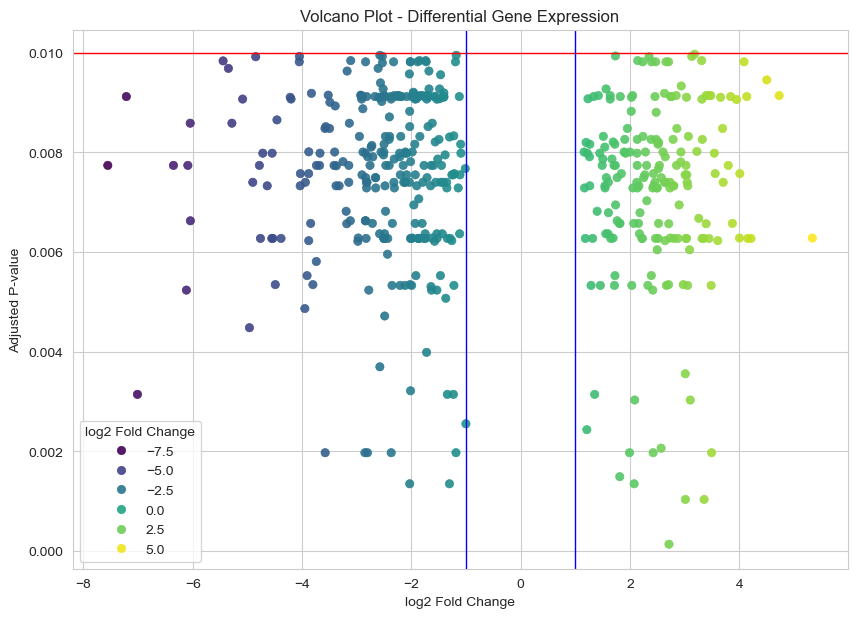

In [38]:
# Visualization of the de los DEGs 
plt.figure(figsize=(10, 7))

# Plot
sns.scatterplot(data=deg_filtered, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None)


plt.axhline(y=0.01, color='red', linestyle='-', linewidth=1)  # line for p-adj = 0.01
plt.axvline(x=1, color='blue', linestyle='-', linewidth=1)   # line for log2FC = 1
plt.axvline(x=-1, color='blue', linestyle='-', linewidth=1)  # line for  log2FC = -1

# Labels and title
plt.xlabel('log2 Fold Change')
plt.ylabel('Adjusted P-value')
plt.title('Volcano Plot - Differential Gene Expression')
plt.legend(title='log2 Fold Change', loc='lower left')


plt.show()
